# Decision Trees and Random Forests
By Adrian Chavez-Loya

A bank is interested in reaching out to customers directly (via phone) to solicit subscriptions to a new product they are planning to offer. The company has over 45k customers and only a small number of phone agents to contact them so targeting those that are most likely to subscribe will maximize their return on investment.

Prior to contacting them, they have asked their Data Science team to analyze customer characteristics for a similar product campaign they ran in the previous year. Your goal is to construct an effective tree-based model to predict whether a customer will subscribe or not.

### Relevant Dataset
`bank-full.csv`
* Response Variable: `y`

### Source of data: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

## Task 1: Import data and construct a random 70/15/15 train/val/test split. Make sure to dummy code categorical variables.

In [4]:
import pandas as pd

df = pd.read_csv('bank-full.csv', delimiter = ";") # Import with delimiter ";" 
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
# Random 70/15/15 train/validation/test split 
import sklearn as skl
from sklearn.model_selection import train_test_split

# Dummy variable categ. variables
df = pd.get_dummies(df, drop_first=True)
print(df.head)


<bound method NDFrame.head of        age  balance  day  duration  campaign  pdays  previous  \
0       58     2143    5       261         1     -1         0   
1       44       29    5       151         1     -1         0   
2       33        2    5        76         1     -1         0   
3       47     1506    5        92         1     -1         0   
4       33        1    5       198         1     -1         0   
...    ...      ...  ...       ...       ...    ...       ...   
45206   51      825   17       977         3     -1         0   
45207   71     1729   17       456         2     -1         0   
45208   72     5715   17      1127         5    184         3   
45209   57      668   17       508         4     -1         0   
45210   37     2971   17       361         2    188        11   

       job_blue-collar  job_entrepreneur  job_housemaid  ...  month_jun  \
0                False             False          False  ...      False   
1                False             Fals

In [6]:
# Features and target
X = df.drop('y_yes', axis=1) 
y = df['y_yes']

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
# Dimensions of train, val., and test set:
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (31647, 42), (31647,)
Validation set: (6782, 42), (6782,)
Test set: (6782, 42), (6782,)


## Task 2: Use Cost-Complexity Pruning to find the optimal depth for a Decision Tree Classifier.

Note: "Optimal" is subjective. Feel free to choose a shallower more interpretable tree or a slightly deeper more accurate tree. Simply explain why you chose the depth you did.

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt 

In [10]:
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Cross-validation to find optimal alpha
clf_scores = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    clf_scores.append(scores.mean())

    

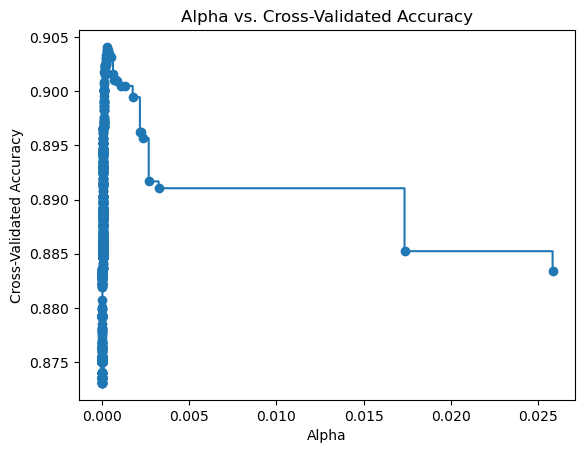

Optimal alpha: 0.000317039596610124
Optimal tree depth: 13


In [33]:
plt.figure()
plt.plot(ccp_alphas, clf_scores, marker='o', drawstyle='steps-post')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Alpha vs. Cross-Validated Accuracy')
plt.show()
# get optimal alpha value
optimal_alpha = ccp_alphas[clf_scores.index(max(clf_scores))]
clf_optimal = DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_alpha)
clf_optimal.fit(X_train, y_train)
print(f"Optimal alpha: {optimal_alpha}")
print(f"Optimal tree depth: {clf_optimal.get_depth()}")

## Task 3: Visualize the "Optimal" tree you fit and interpret the first few splits to the best of your ability.

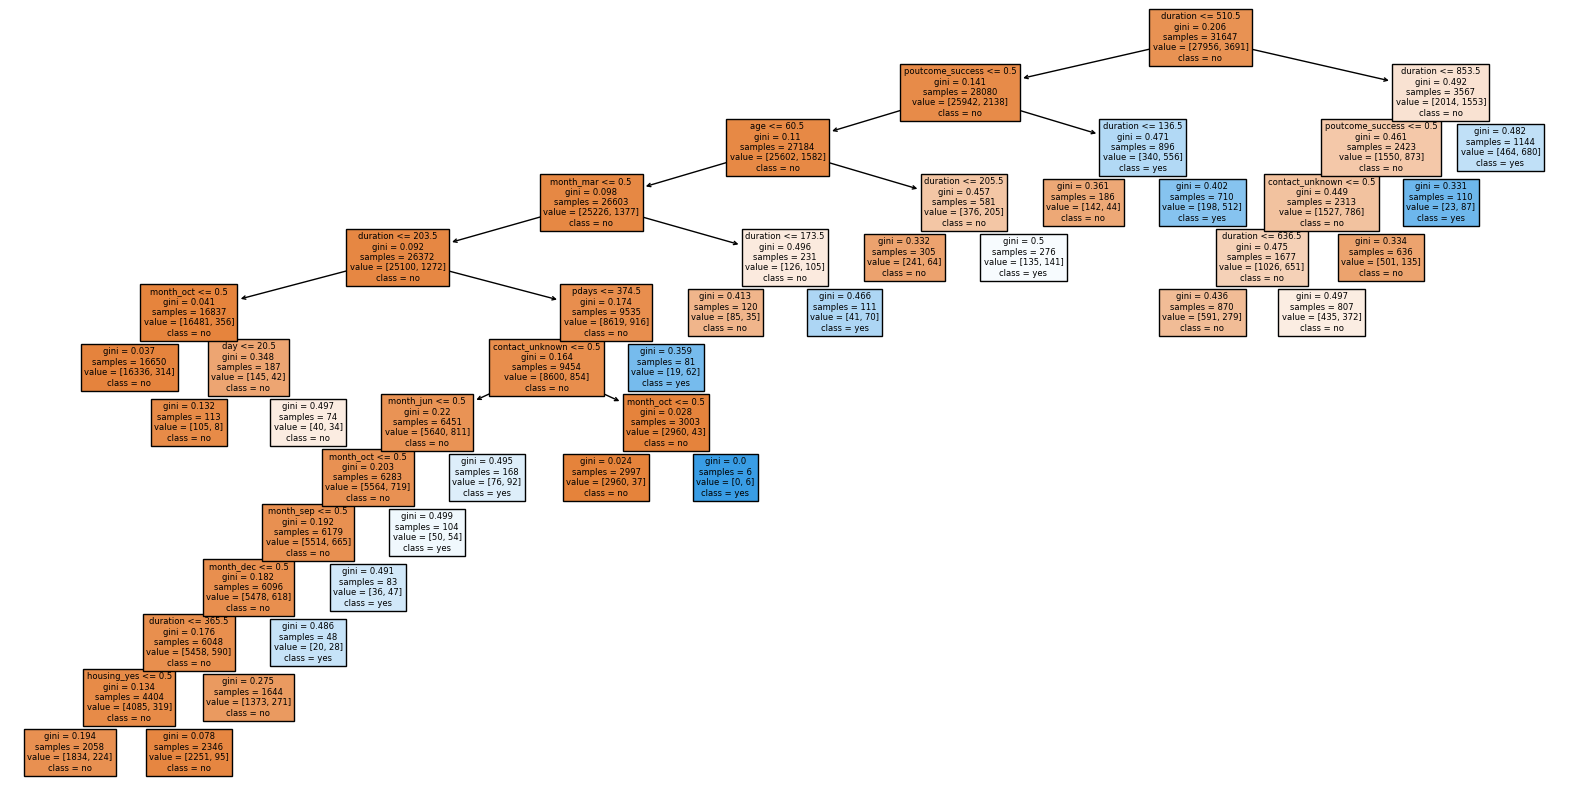

In [16]:
from sklearn.tree import plot_tree

# Convert feature names to a list
feature_names = X.columns.tolist()

# Plot the optimal decision tree
plt.figure(figsize=(20,10))
plot_tree(clf_optimal, filled=True, feature_names=feature_names, class_names=['no', 'yes'])
plt.show()


The decision tree model starts by splitting on `duration <= 203.5`, with a Gini index of 0.092 and a majority class of `no`. For samples with `duration <= 203.5`, the next split is on `month_oct <= 0.5`, achieving a Gini index of 0.041, still dominated by the `no` class. If `month_oct > 0.5`, it further splits on `day <= 20.5` with a moderate Gini index of 0.348. For `duration > 203.5`, the model splits again on `duration <= 510.5` with a Gini index of 0.206, maintaining `no` as the majority class. Subsequent splits for `duration <= 203.5` and `month_oct <= 0.5` include `month_jun <= 0.5`, achieving a Gini index of 0.022. Overall, `duration` and `month` features are critical in classifying the samples.

## Task 4: Calculate the k-fold CV accuracy for predicting 'yes' or 'no' using a Decision Tree Classifier.

In [18]:
from sklearn.model_selection import cross_val_score

# Using the optimal Decision Tree from Task 2
cv_scores = cross_val_score(clf_optimal, X, y, cv=5)
print(f"5-Fold CV accuracy: {cv_scores.mean()}")


5-Fold CV accuracy: 0.6643467570446618


* 5-fold CV accuracy is 66.4 percent

## Task 5: Fit a Random Forest Classifier and use the OOB accuracy to choose the optimal number of trees and/or variables sampled at each split.

Note: The argument for number of trees is `n_estimators` in scikit-learn and the number of variables to consider at each split is `max_features`.

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Fit a Random Forest with default parameters to check OOB score
rf_clf = RandomForestClassifier(oob_score=True, random_state=42)
rf_clf.fit(X_train, y_train)
print(f"OOB score: {rf_clf.oob_score_}")

# Experiment with different number of trees and max_features to optimize OOB score
best_oob_score = 0
best_params = {}

for n_estimators in [50, 100, 200]:
    for max_features in [None, 'sqrt', 'log2']:
        rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, oob_score=True, random_state=42)
        rf_clf.fit(X_train, y_train)
        if rf_clf.oob_score_ > best_oob_score:
            best_oob_score = rf_clf.oob_score_
            best_params = {'n_estimators': n_estimators, 'max_features': max_features}

print(f"Best OOB score: {best_oob_score}")
print(f"Best parameters: {best_params}")

# Fit the Random Forest with the best parameters
rf_best = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_features=best_params['max_features'], oob_score=True, random_state=42)
rf_best.fit(X_train, y_train)
print(f"Best OOB Score: {rf_best.oob_score_}")
print(f"Best Parameters: {best_params}")



OOB score: 0.901602047587449
Best OOB score: 0.9044143204727146
Best parameters: {'n_estimators': 200, 'max_features': 'log2'}
Best OOB Score: 0.9044143204727146
Best Parameters: {'n_estimators': 200, 'max_features': 'log2'}


## Task 6: Report impurity based feature importance for your final selected model in a bar chart. 

Optional: If you are curious, try running permutation importance (note: this may take a while) and compare the two

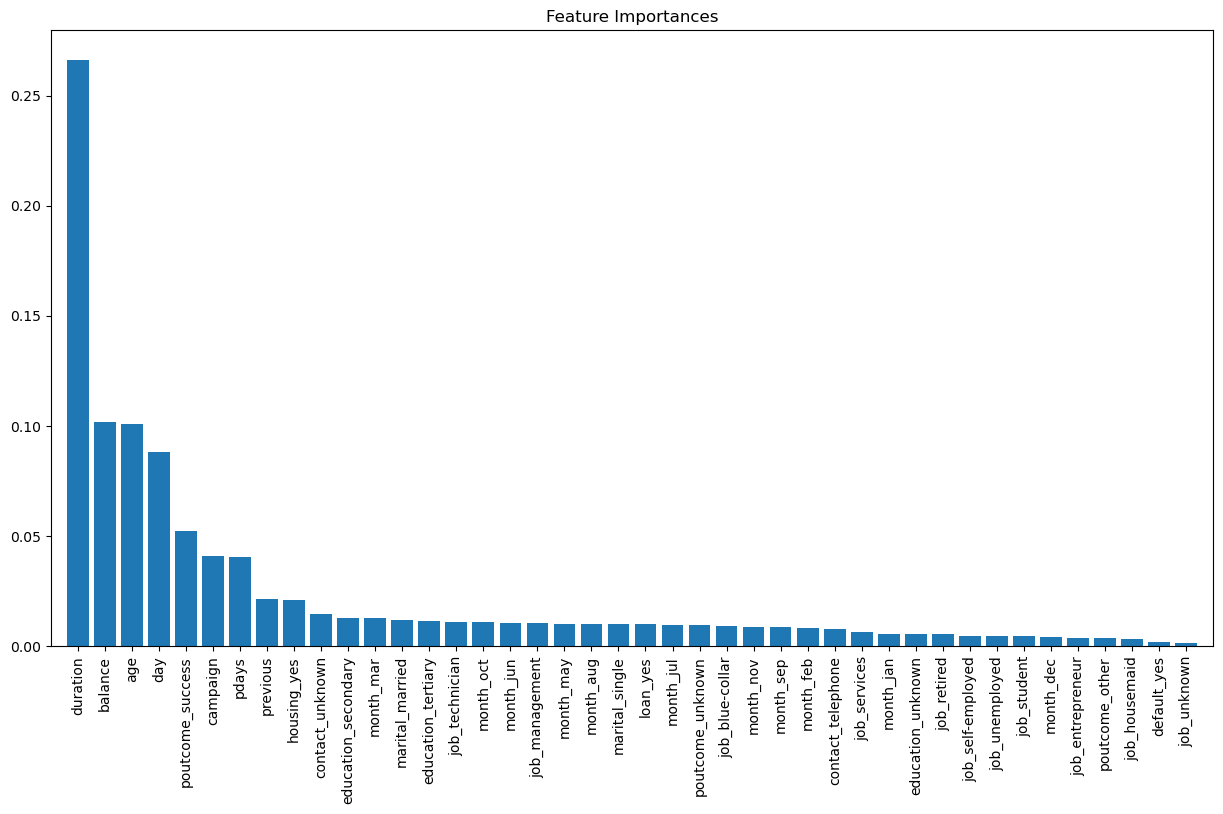

In [25]:
import numpy as np

importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

# Order highest feature importances
plt.figure(figsize=(15, 8))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


## Task 7: Choose the model with the best cross-validated or OOB accuracy between Decision Trees and Random Forests and provide the Partial Dependence Plots for the 5 most important variables.

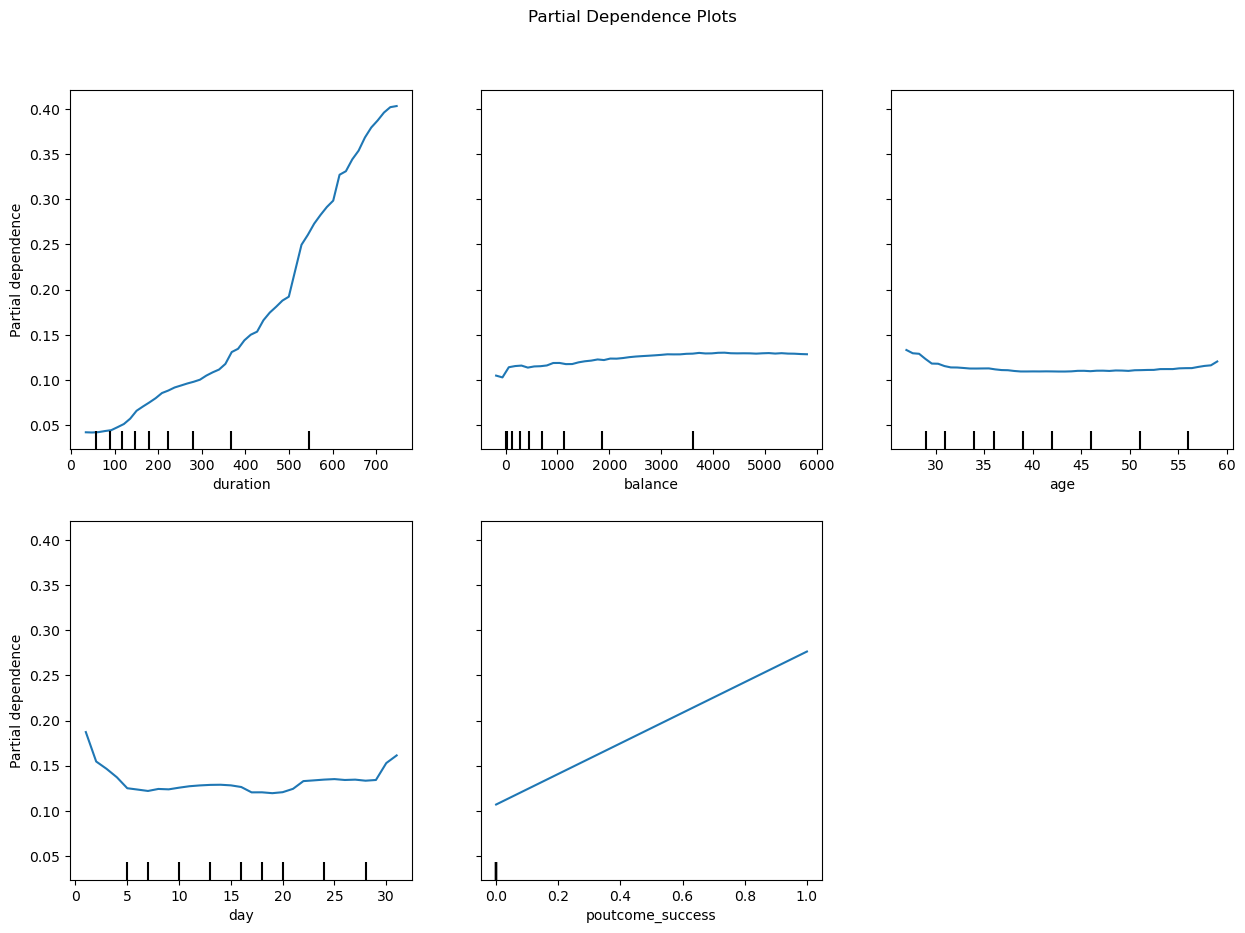

In [31]:
from sklearn.inspection import PartialDependenceDisplay

top_5_features = features[indices[:5]] # Top 5 Features 
fig, ax = plt.subplots(figsize=(15, 10))
PartialDependenceDisplay.from_estimator(rf_best, X_train, top_5_features, ax=ax, grid_resolution=50)
plt.suptitle('Partial Dependence Plots')
plt.subplots_adjust(top=0.9)  # Adjust title position
plt.show()